# Keyword Detection on Websites

## Objective 
+ Create an algorithm, that takes html page as input and infers if the page contains the information about cancer tumorboard or not

## What is a tumor board?
+ Tumor Board is a consilium of doctors (usually from different disciplines) discussing cancer cases in their departments

### Initial Steps

+ Read in test, train and keyword csv's
+ Prepare to use beautiful soup to parse the HTML content needed
+ Install lxml, an HMTL parser

In [1]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# reading in training csv
train_df = pd.read_csv(filepath_or_buffer = 'detection_train.csv')

# printing out 10 random samples from the dataset
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1


In [2]:
# reading in training csv
test_df = pd.read_csv('detection_test.csv')

# printing out 10 random samples from the dataset
test_df.sample(n = 10, random_state = 42)

,url,doc_id
27,http://www.josephstift-dresden.de/pressemittei...,71
40,http://www.pius-hospital.de/kliniken/gynaekolo...,123
26,http://www.interdisziplinaere-endoskopie.mri.t...,70
43,http://www.uk-augsburg.de/krebsbehandlung/diag...,134
24,http://www.hjk-muenster.de/unsere-kompetenzen/...,68
37,http://www.maria-josef-hospital.de/unsere-komp...,109
12,http://www.ctk.de/klinikum/karriere/stellenang...,46
19,http://www.gesundheitszentrum-wetterau.de/342/...,59
4,http://marienhospital-buer.de/mhb-av-chirurgie...,16
25,http://www.hufeland.de/de/abteilung-fuer-gastr...,69


In [3]:
# reading in training csv
keyword_df = pd.read_csv('keyword2tumor_type.csv')

# printing out 10 random samples from the dataset
keyword_df.sample(n = 10, random_state = 42)

,keyword,tumor_type
73,magen,Magen
19,malignome,Endokrine malignome
116,molekulare,Molekular
67,transit,Lymphom
94,bone,Sarkome
77,mammographie,Mamma carcinoma
31,gynäkologische,Gynäkologie
53,thyroid,Kopf-hals
117,oral,Oral
44,lympho,Hämatooncology


In [4]:
# now let's understand the distribution of labels across the training doc

train_df['label'].value_counts().reset_index()

,index,label
0,2,59
1,1,32
2,3,9


### Next steps

+ Load the data to read the HTML files
+ Create a function that will load the corresponding HTML file from the htmls directory
+ Get the HMTL contents and store it in a new column called "html"
+ Since the documents are in German, the encoding cannot be utf-8 which is commonly used, instead latin1 will be used

In [5]:
# defining a function to read an HMTL file given a document ID
def read_html(doc_id: int) -> str:
    # open the HTML file with the given document ID
    with open(file=f"htmls/{doc_id}.html",
              mode="r",
              encoding="latin1") as f:
        # read the contents of the file and store it as a string
        html = f.read()
    # return the HMTL string    
    return html


# apply the read_html function to each value in the "doc_id" column of the train_df dataframe
# and store the resulting HTML strings in a new column called "html"
train_df["html"] = train_df["doc_id"].apply(read_html)

In [6]:
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label,html
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_..."
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or..."
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<..."
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me..."
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3,"<!DOCTYPE html>\n<!--[if lt IE 7 ]><html dir=""..."
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2,"<!DOCTYPE html> <html class=""no-js""> <head> <m..."
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1,"<!DOCTYPE html>\n<html class=""no-js"">\n<meta h..."
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...


### Parsing the HTML Content

+ Use the package BeautifulSoup to parse through the HTML content for the data we need
+ On top of BeautifulSoup, we will use the a proper HMTL parser, which is the lxml library
+ Build a function that extracts the text

In [7]:
import warnings

from bs4 import BeautifulSoup

# filtering warning messages
warnings.filterwarnings(action = "ignore")

# defining a function to extract text from HTML
def extract_html(html: str) -> str:
    # creating a beautiful soup object and parsing the HTML
    bs = BeautifulSoup(markup = html, features = 'lxml')
    # removing script and style tags
    for script in bs(name = ['script', 'style']):
        script.decompose()
    # getting the text content after removing script style tags
    return bs.get_text(separator = "")

# applying the extract html function to the html column
train_df['html_text'] = train_df['html'].apply(extract_html)

In [8]:
# displaying the dataframe to ensure the function worked appropriately
train_df.sample(n = 10, random_state = 42)

,url,doc_id,label,html,html_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n\n\n\n\nProstata-Karzinom-Zentrum - Schwarzw...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n\n\n\nDarmzentrum Rheinpfalz » Zentren A-Z »...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
39,http://www.gesundheit-nordhessen.de/klinikum-k...,57,3,"<!DOCTYPE html>\n<!--[if lt IE 7 ]><html dir=""...",\n\n\n\n\n\nInterdisziplinÃ¤re Zusammenarbeit ...
22,http://stereotaxie.uk-koeln.de/erkrankungen-th...,28,2,"<!DOCTYPE html> <html class=""no-js""> <head> <m...",Radiochirurgie - Hirntumore - Erkrank...
80,http://www.neurochirurgie.uk-erlangen.de/forsc...,120,1,"<!DOCTYPE html>\n<html class=""no-js"">\n<meta h...",\n\n\n\n\nNeurochirurgie\n\n\n\n\n\n\n\n\n\n\n...
10,http://krebszentrum.kreiskliniken-reutlingen.d...,13,2,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",\n\n\nKrebszentrum Reutlingen: Zentrale Einric...
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...,\n\n\n\n\n\nElbe-Elster Klinikum - Chirurgie F...


### Next Steps

+ The HTML text has been extracted but it contrains a lot of new line symbols (\n)
+ In order to remove these characters from the html_text, the text must be cleaned or preprocessed
+ Since we are looking to keyword detections, remove any other unnecessary characters
+ Write a function to remove non-alphanumeric characters, multiple whitespaces and numerical characters
+ We will also remove any stop words

### How the function will work in steps

1. Strips all non-alphanumerical characters
2. Strips all multiple whitespaces
3. Strips all punctuation
4. Strips all numerical characters
5. Converts to lowercase and then stems the text
6. Removes all stop-words

### What does stop words mean?

+ Stop words are common words that occur frequently in a language, but are not very informative or meaningful for natural language processing tasks. Examples of stop words in English include words like "the", "a", "an", "and", "in", "of", "to", etc

### Once that is completed

+ Once the chracters aforementioned are removed, the next step is to perform an Exploratory Data Analysis of the dataset

In [9]:
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

def preprocess_html_text(html_text: str) -> str:
    stemmer = SnowballStemmer("english")         # initializing Snowball stemmer for English language
    stop_words = stopwords.words('english')      # getting english stop words
    text = html_text.lower()                     # converting the text to lower case
    text = re.sub(r'\W', ' ', text)              # replace non-alphanumeric characters with whitespace
    text = re.sub(r'\s+', ' ', text)             # # replace multiple whitespaces with single whitespace
    text = re.sub(r'\d+', '', text)              # # remove numerical characters
    tokens = text.split()                        # splitting and tokenizing the text
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]  # # apply stemming and remove stop words through a list comprehension
    return " ".join(tokens)                      # join the tokens back together to form the preprocessed text

# applying function to the html_text column and storing the preprocessed text in a new column
train_df['preprocessed_text'] = train_df['html_text'].apply(preprocess_html_text)

In [10]:
# displaying dataframe to ensure the preprocessing was successful
train_df.sample(n = 5, random_state = 42)

,url,doc_id,label,html,html_text,preprocessed_text
83,http://www.sbk-vs.de/de/medizin/leistungen-und...,125,1,"\n\n<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""de_...",\n\n\n\n\nProstata-Karzinom-Zentrum - Schwarzw...,prostata karzinom zentrum schwarzwald baar kli...
53,http://www.klinikum-esslingen.de/kliniken-und-...,85,2,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,unser profil gefã ã und thoraxchirurgi kliniku...
70,http://www.malteser-kliniken-rhein-ruhr.de/med...,107,2,"<!DOCTYPE html>\n<html lang=""de"">\n<head>\n\n<...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,maltes kliniken rhein ruhr darmzentrum duisbur...
45,http://www.klilu.de/medizin__pflege/kliniken_u...,73,2,"<!DOCTYPE html>\n<html lang=""de""><head>\n\t<me...",\n\n\n\nDarmzentrum Rheinpfalz » Zentren A-Z »...,darmzentrum rheinpfalz zentren z kliniken und ...
44,http://www.kk-bochum.de/de/kliniken_zentren_be...,72,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,mund kiefer und plastisch gesichtschirurgi de ...


## Exploratory Data Analysis

#### Questions to address

+ What is the average length of characters per text? 
+ What about average amount of words per text?
+ Since we are building a model to detect key words, unique words are important. What does that distribution look like?


#### Takeaways 

+ Are there any outliers?
+ Can we draw assumptions on the data by looking at some visuals?

#### Approach

+ Apply the .len function to preprocessed text to count the total number of characters per article and store it in a new column
+ Use the 'str' accessor to split the text directly and applying the .len function to calculate numbers of words per article and store it in a new column

In [11]:
# importing plotly
import plotly.express as px
import plotly.offline as pyo

# set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)

In [12]:
train_df['character count'] = train_df['preprocessed_text'].apply(len)

train_df['word count'] = train_df['preprocessed_text'].str.split().apply(len)

train_df

,url,doc_id,label,html,html_text,preprocessed_text,character count,word count
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1,<!DOCTYPE html>\n<!-- jsn_reta_pro 1.0.2 -->\n...,\n\n\n\n\n\nElbe-Elster Klinikum - Chirurgie F...,elb elster klinikum chirurgi finsterwald suche...,8326,960
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",\n\n\n\n\n\n\nOnkologisches Zentrum - Klinikum...,onkologisch zentrum klinikum bayreuth aktuel ã...,22752,2742
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nZentrum - SozialpÃ¤diatrisches Zentrum - S...,zentrum sozialpã diatrisch zentrum stã dtisch ...,9021,1062
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nLeistung - Spezielle UnterstÃ¼tzung bei de...,leistung speziell unterstã¼tzung bei der anmel...,4052,414
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3,"<!doctype html>\n<html lang=""de"">\n<head>\n\t<...",\n\nZuweiser - Tumorkonferenzen - Tumorkonfere...,zuweis tumorkonferenzen tumorkonferenz gastroi...,4378,434
...,...,...,...,...,...,...,...,...
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1,"<!DOCTYPE html>\n<html lang=""de-DE""\nprefix=""o...",\n\n\n\n\n\n\n\n\n\n\nuniFM | uniCROSS\n\n\n\n...,unifm unicross news magazin theme home wir mac...,176782,27209
96,http://www.uniklinik-duesseldorf.de/patienten-...,141,1,"<!DOCTYPE html>\n<html class=""no-js"" lang=""de""...",\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nInterdis...,interdisziplinã neurovaskulã konferenz ǀ ukd j...,7046,835
97,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,144,2,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""d...",\n\n\n\n\n\n\n\n\n\n\n\nFÃ¼r Ãrzte | Vivantes...,fã¼r ã rzte vivant javascript scheint ihrem br...,13385,1613
98,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,145,2,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""d...",\n\n\n\n\n\n\n\n\n\n\n\n\n\nInnere Medizin â...,inner medizin â hã matologi onkologi und palli...,15443,1882


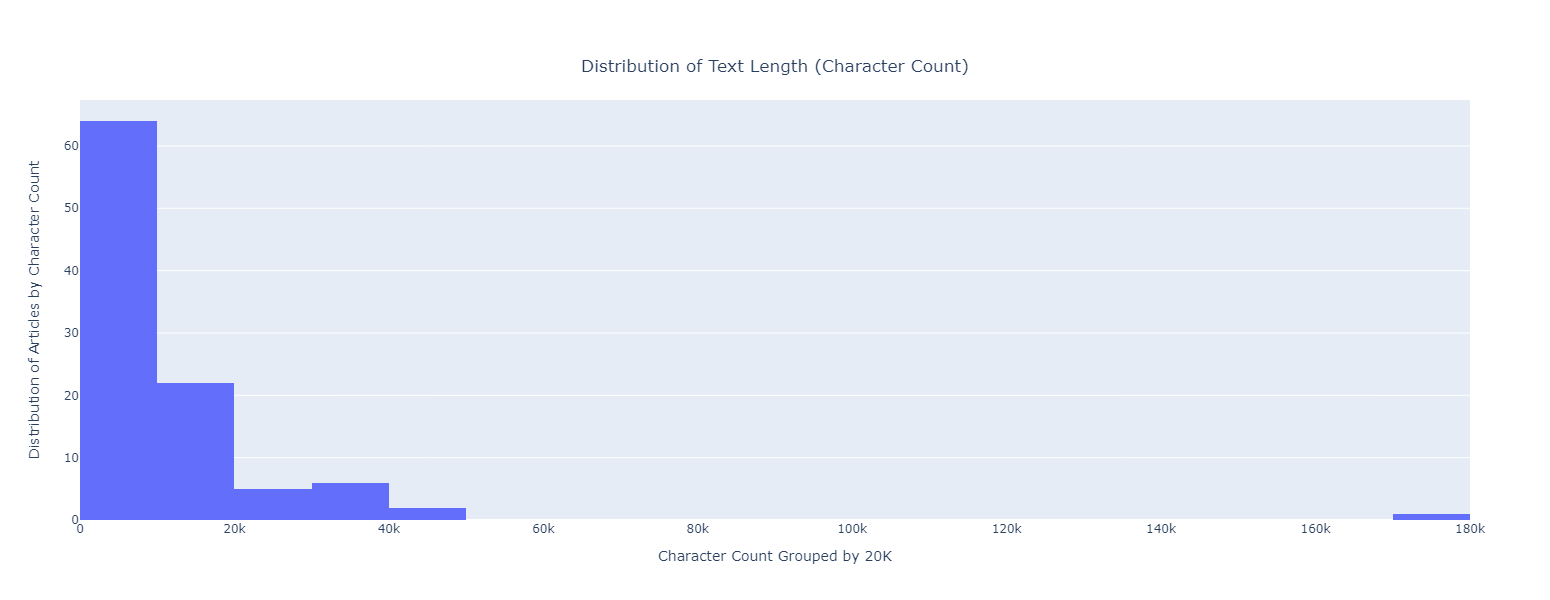

In [14]:
fig = px.histogram( x = train_df["character count"],
             title="Distribution of Text Length (Character Count)",
             height = 600,
             labels = dict(x = "Character Count Grouped by 20K"))

fig.update_yaxes(title_text = "Distribution of Articles by Character Count")

fig.update_layout(title = {'y' : 0.9, 'x' : 0.5})

### Character Count Takeaways

+ There is only one article that has over 50K characters
+ 86% of articles fall under 20K articles 

### Next

+ This is useful information, but there is more that is needed to explore
+ Understanding average words per article, as well as unique words is needed